##Problem Statement

The goal of Kaggle challenge are:
- Predict FVC decline based on high resolution CT scan 
- Engage with a large community of AI experts
- Promote interest from a broader community

Challenge is designed in the following way:
- CT Image at t1, FVC at t1 and FVC at t2
- Try to predict relative or absolute FVC decline give CT(1) and FVC(t1)

Next steps/Roadmap
Perform initial data, sanity check and performance of baseline algorithms

**FEV1 and FVC**
The FEV1/FVC ratio, also called Tiffeneau-Pinelli index,[1] is a calculated ratio used in the diagnosis of obstructive and restrictive lung disease.[2][3] It represents the proportion of a person's vital capacity that they are able to expire in the first second of forced expiration (FEV1) to the full, forced vital capacity (FVC).[4] The result of this ratio is expressed as FEV1%.
https://en.wikipedia.org/wiki/FEV1/FVC_ratio

**Laplace Distribution:** https://en.wikipedia.org/wiki/Laplace_distribution

**Log Laplace distribution:** https://en.wikipedia.org/wiki/Log-Laplace_distribution

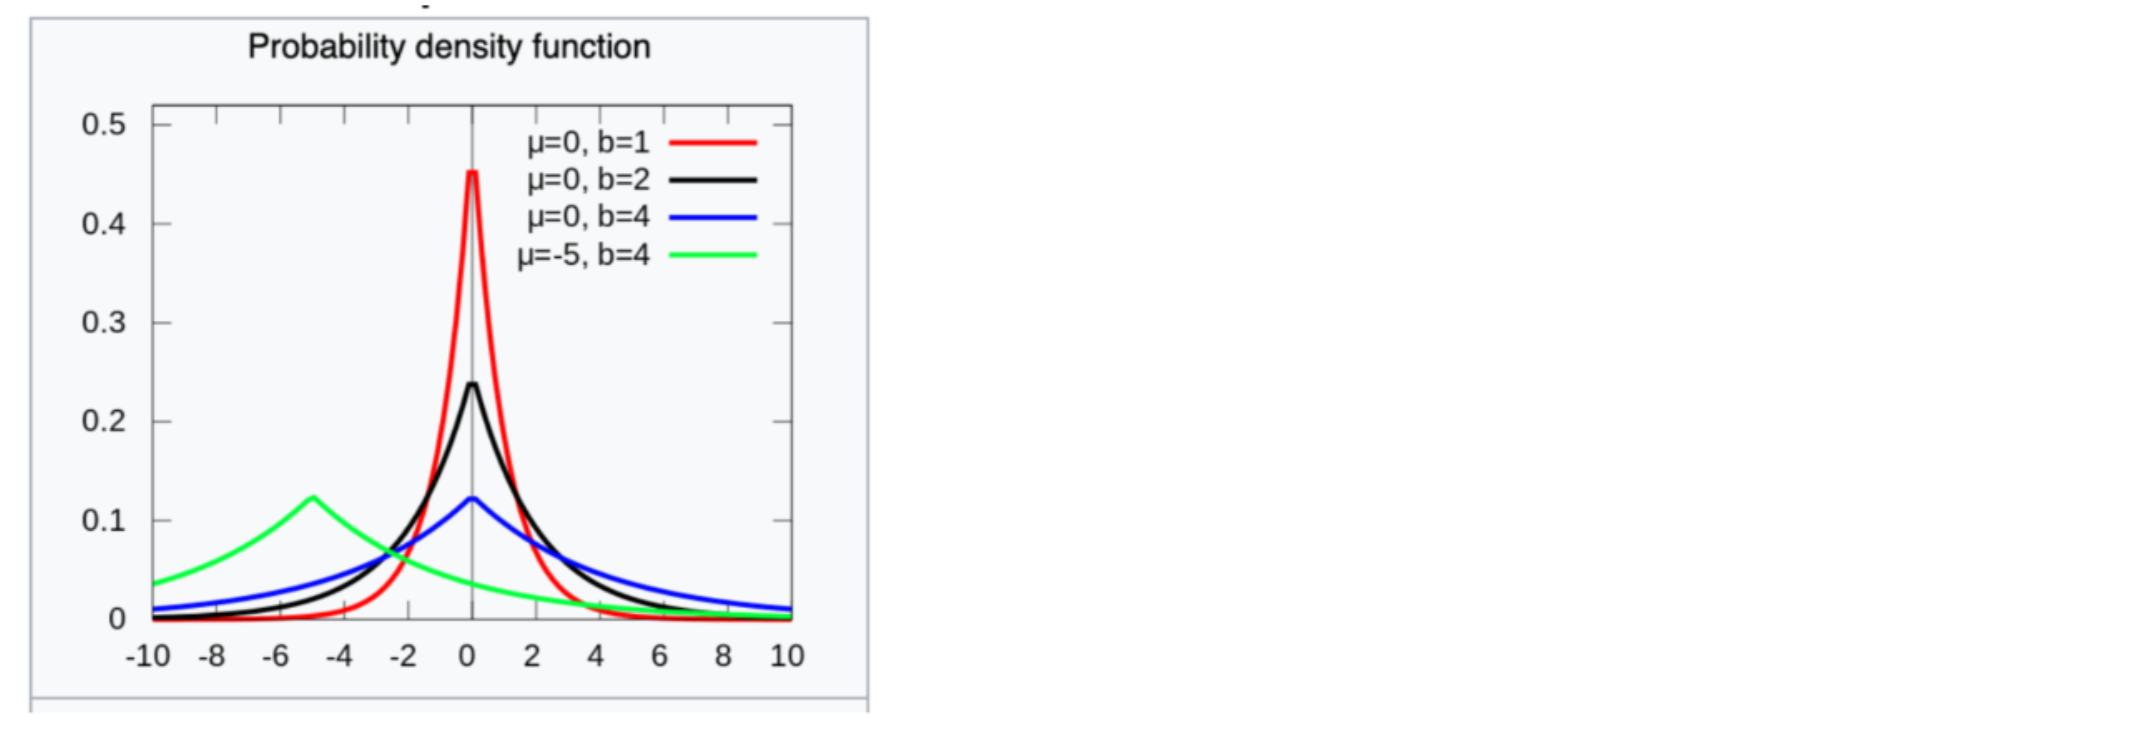

### Evaluation

The evaluation metric of this competition is a modified version of Laplace Log Likelihood
https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/overview/evaluation

In medical applications, it is useful to evaluate a model's confidence in its decisions. Accordingly, the metric is designed to reflect both the accuracy and certainty of each prediction.

For each true FVC measurement, you will predict both an FVC and a confidence measure (standard deviation σ).

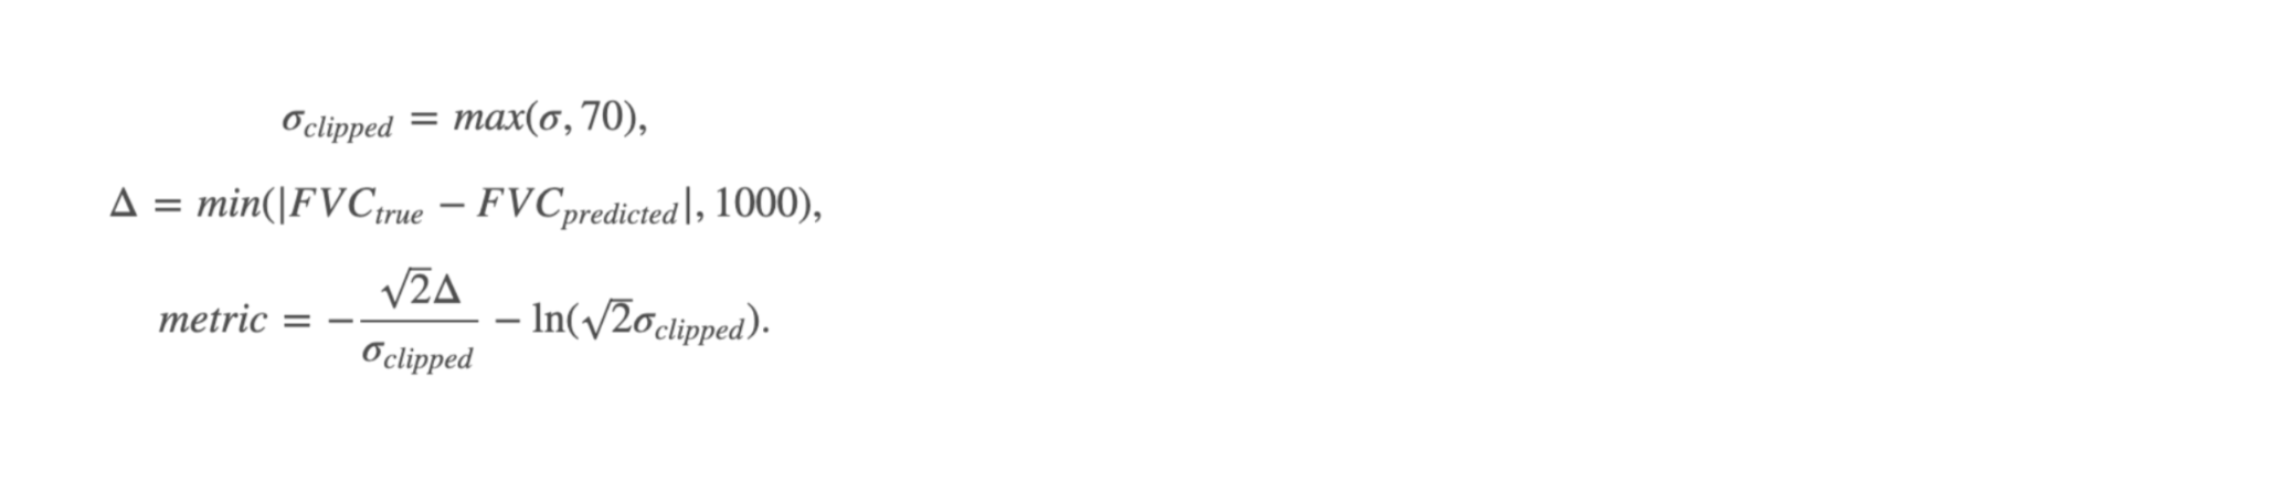

###Evaluating our Data

FVC ranges from **827 to 6399** and seems to have a (visually) normal distribution with mean **2690 and standard deviation 833.**


**-8.023** is the default score to beat while cross-validating models on train data. Any modelscoring worse than this is not useful

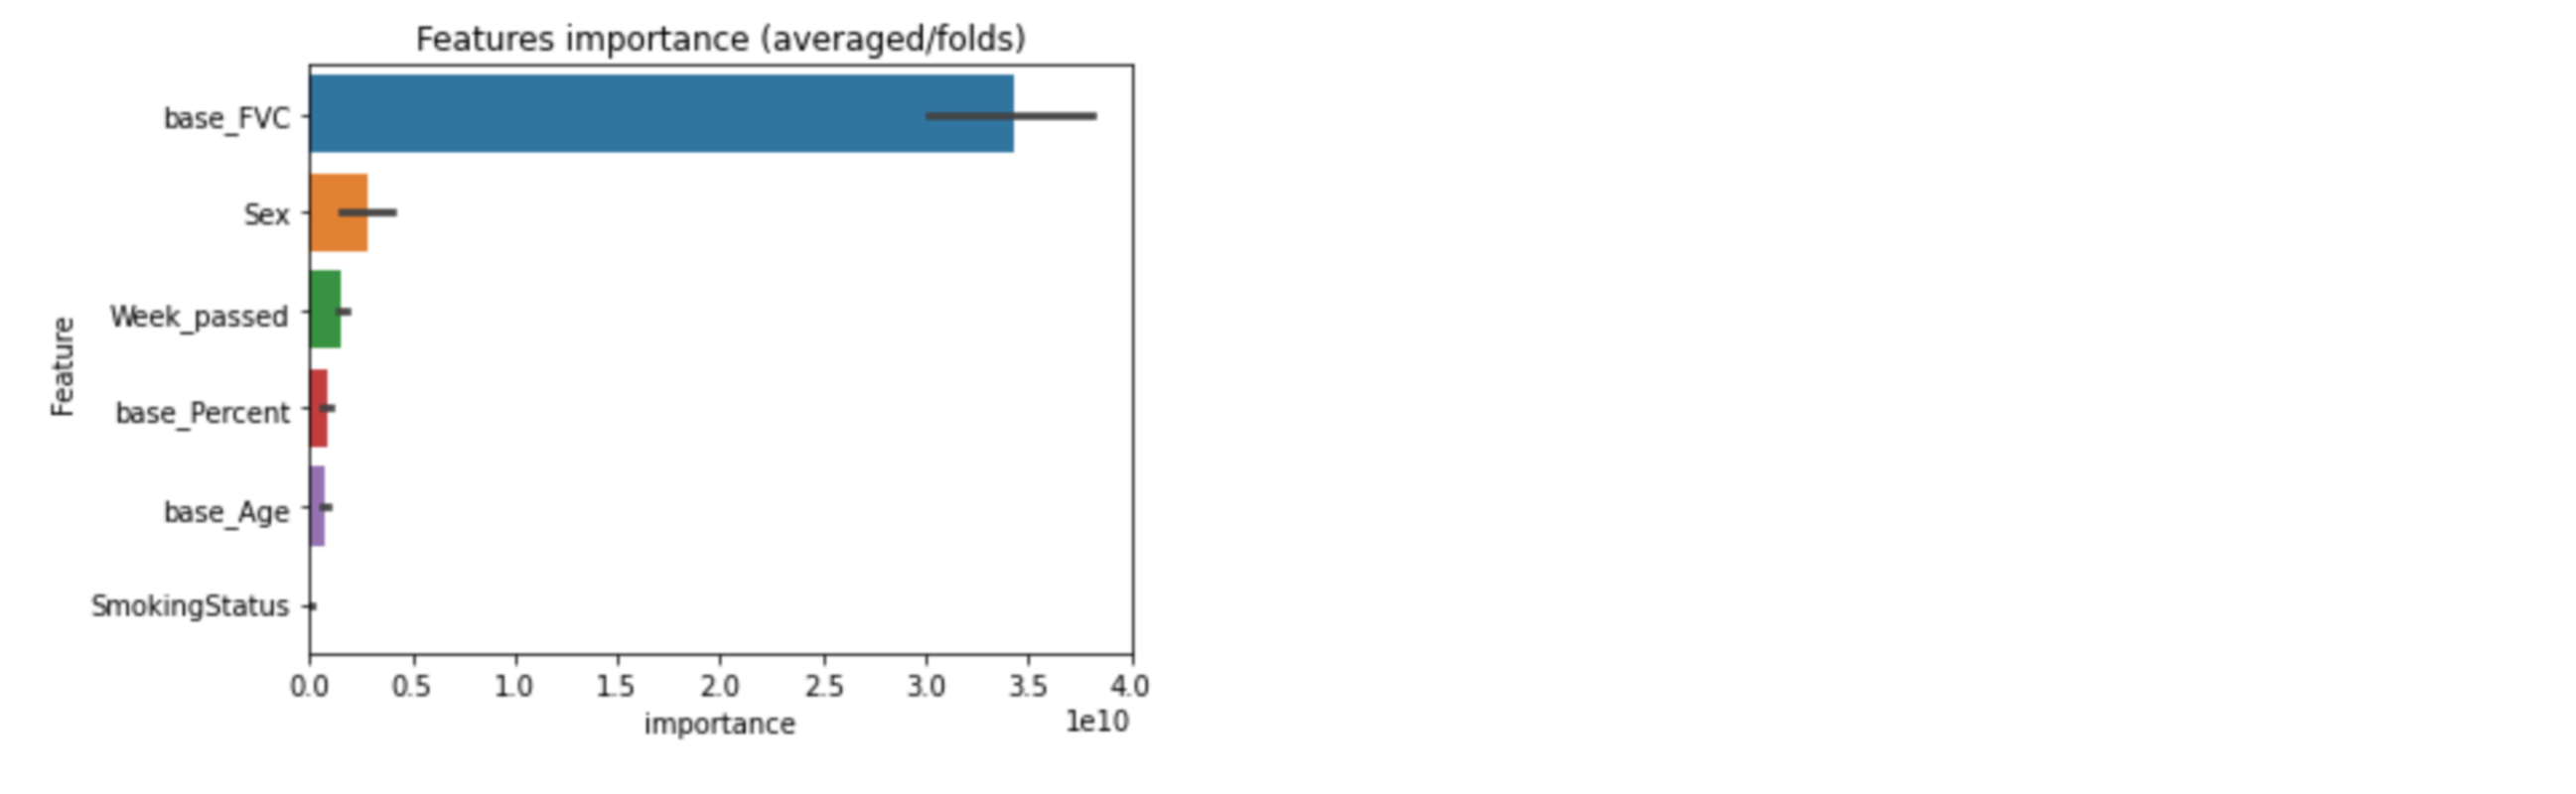

###FVC Distribution 

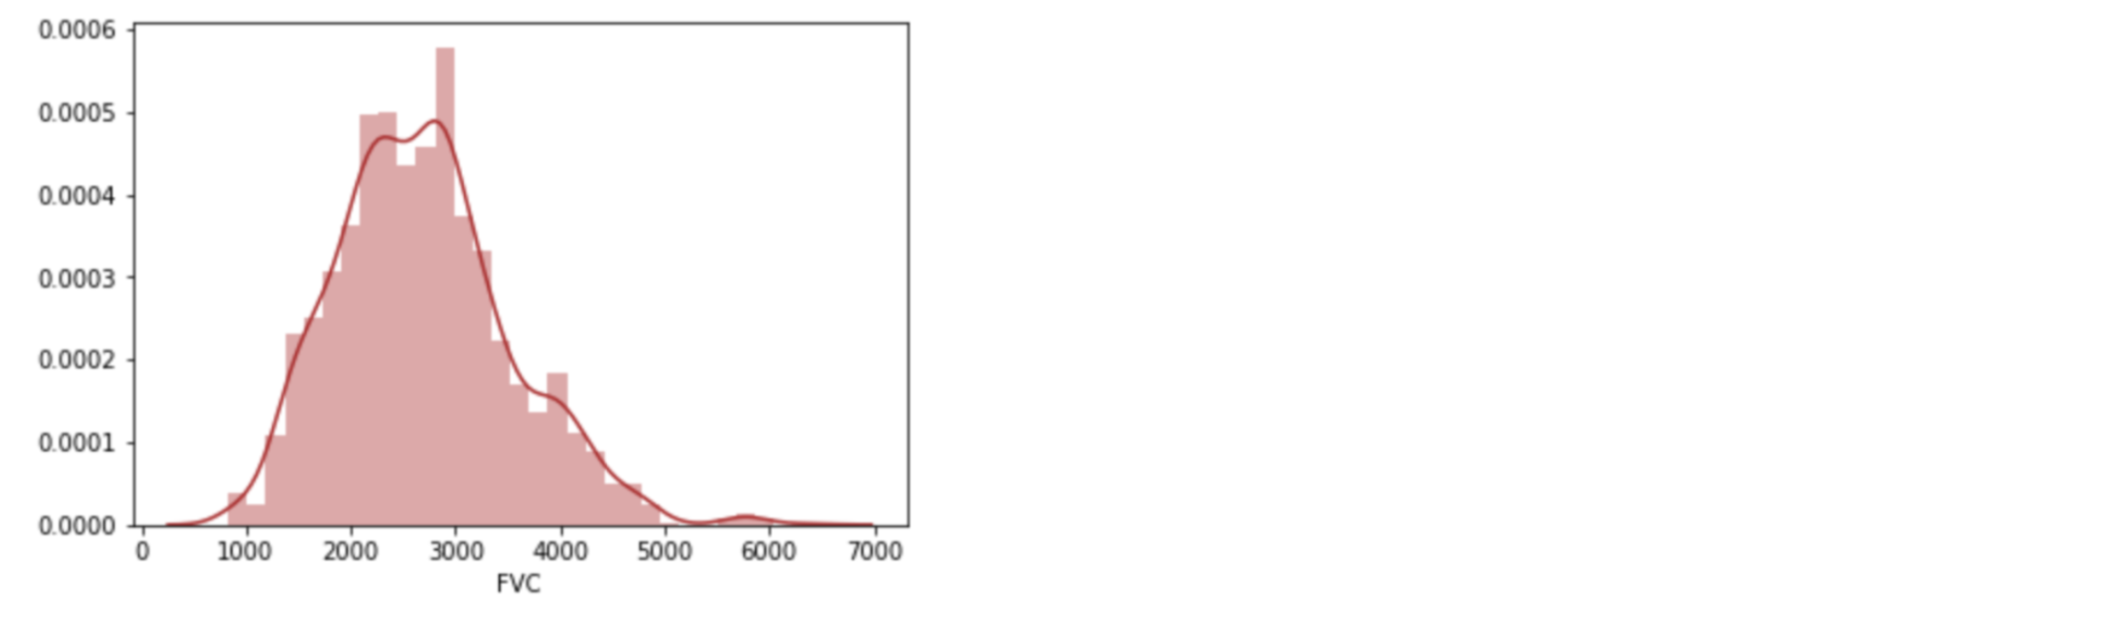

### Optimized Score Metric

### Predict Confidence
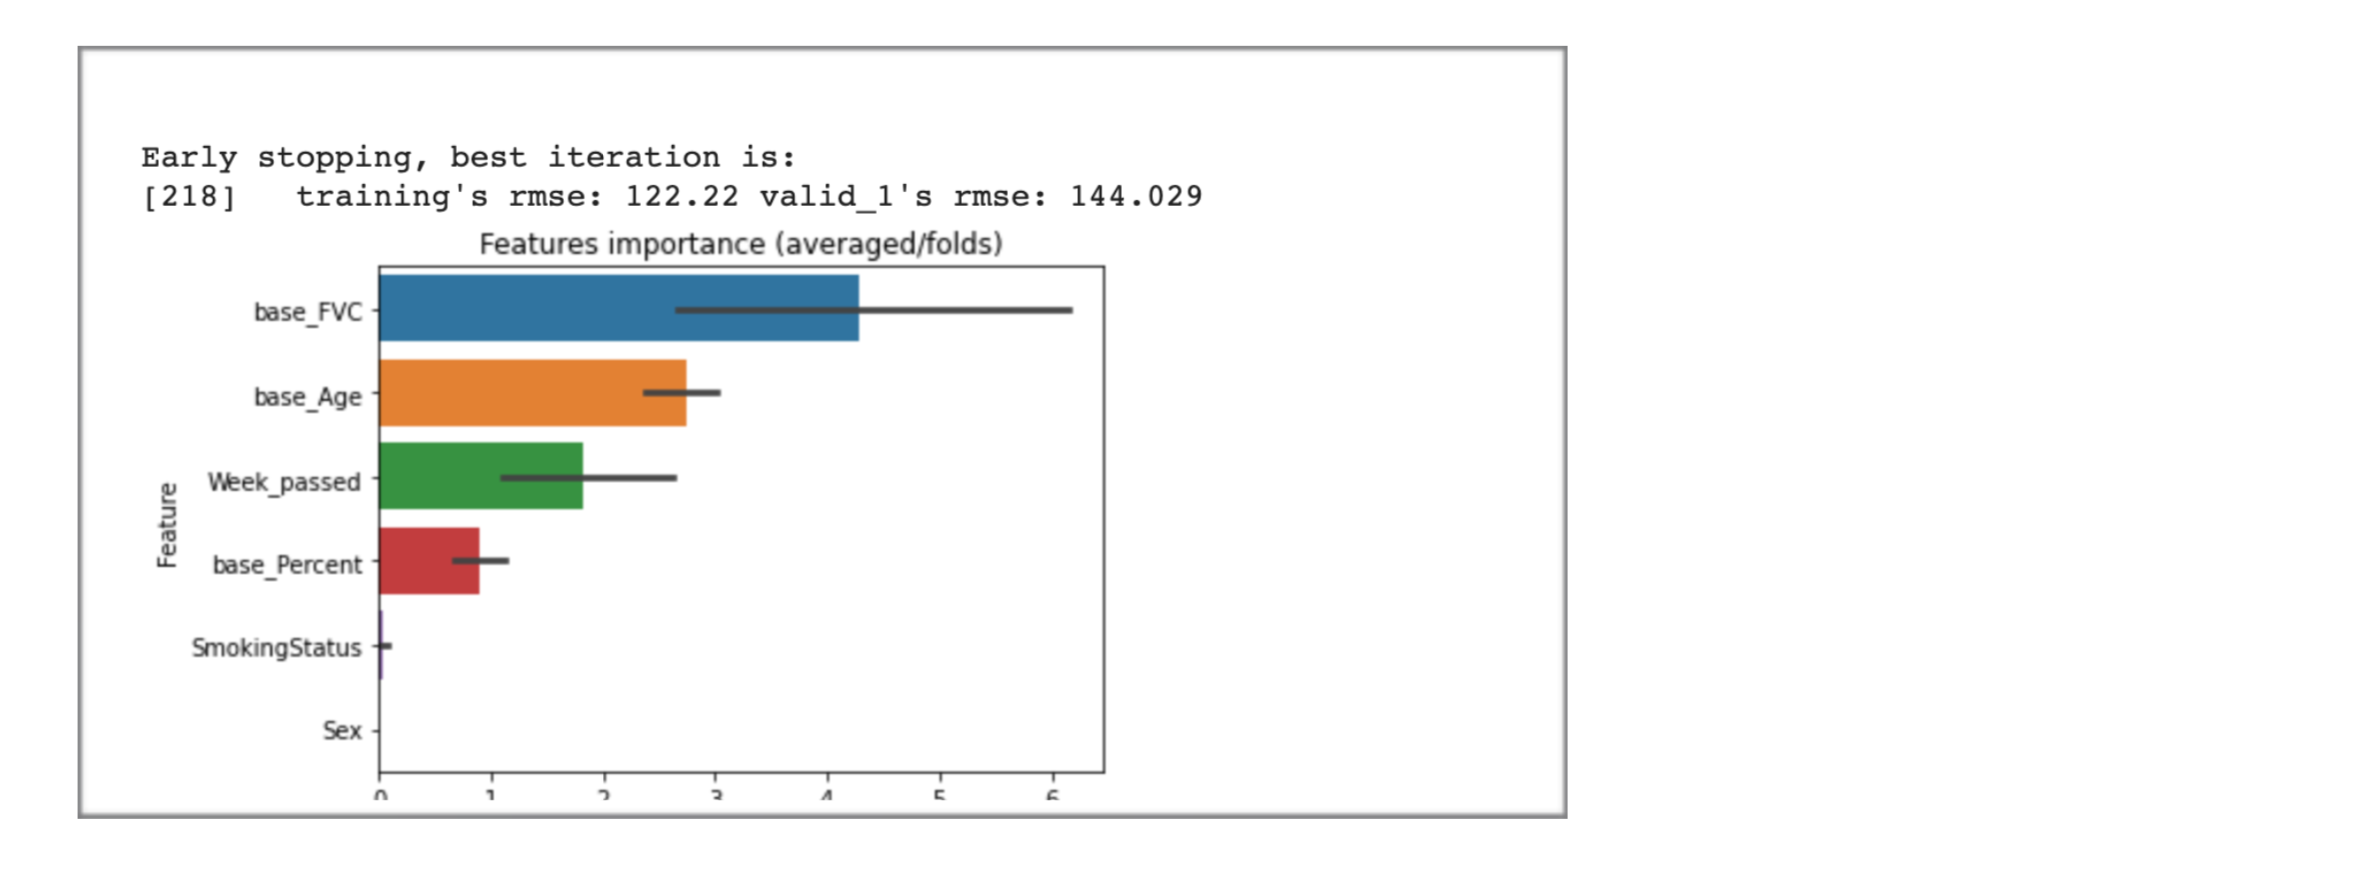

### Source Code

In [ ]:
## importing packages
import numpy as np
import pandas as pd

#Use seaborn API for plotting functions
import seaborn as sns

#Bokeh library for interactive visualization that targets web browsers for representation.
from bokeh.layouts import row, column
from bokeh.models import ColumnDataSource, CustomJS, Label, Range1d, Slider, Span
from bokeh.plotting import figure, output_notebook, show

output_notebook()

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import mean_squared_error

from PIL import Image
import cv2
!pip install pydicom  -q
import pydicom
import torch

import lightgbm as lgb
from sklearn.linear_model import Ridge

!pip install --upgrade category_encoders
import category_encoders as ce

import os
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
from functools import partial
import random 


import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/data/')

Drive already mounted at /data/; to attempt to forcibly remount, call drive.mount("/data/", force_remount=True).


In [ ]:
## reading data
df_train = pd.read_csv("/data/My Drive/data/osic-pulmonary-fibrosis-progression/train.csv")
print(df_train)
print(df_train.FVC)
df_train.head(5)

                        Patient  Weeks   FVC  ...  Age   Sex SmokingStatus
0     ID00007637202177411956430     -4  2315  ...   79  Male     Ex-smoker
1     ID00007637202177411956430      5  2214  ...   79  Male     Ex-smoker
2     ID00007637202177411956430      7  2061  ...   79  Male     Ex-smoker
3     ID00007637202177411956430      9  2144  ...   79  Male     Ex-smoker
4     ID00007637202177411956430     11  2069  ...   79  Male     Ex-smoker
...                         ...    ...   ...  ...  ...   ...           ...
1544  ID00426637202313170790466     13  2712  ...   73  Male  Never smoked
1545  ID00426637202313170790466     19  2978  ...   73  Male  Never smoked
1546  ID00426637202313170790466     31  2908  ...   73  Male  Never smoked
1547  ID00426637202313170790466     43  2975  ...   73  Male  Never smoked
1548  ID00426637202313170790466     59  2774  ...   73  Male  Never smoked

[1549 rows x 7 columns]
0       2315
1       2214
2       2061
3       2144
4       2069
        ..

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [ ]:
#Smoking Status 
df_train.groupby(['SmokingStatus']).count()['Sex'].to_frame()

,Sex
SmokingStatus,
Currently smokes,82
Ex-smoker,1038
Never smoked,429


Util Functions

In [ ]:

def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

  Data Loading

In [ ]:
OUTPUT_DICT = './'

ID = 'Patient_Week'
TARGET = 'FVC'
SEED = 42

seed_everything(seed=SEED)

N_FOLD = 4
train = df_train
train[ID] = train['Patient'].astype(str) + '_' + train['Weeks'].astype(str)
print(train.shape)
train.head()

(1549, 8)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Patient_Week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,ID00007637202177411956430_-4
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,ID00007637202177411956430_5
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,ID00007637202177411956430_7
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,ID00007637202177411956430_9
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,ID00007637202177411956430_11


Data NULL Values 


In [ ]:
# Null values and Data types
print(df_train.info())
print('-------------')
df_test = pd.read_csv(
    "/data/My Drive/data/osic-pulmonary-fibrosis-progression/test.csv")
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        5 non-null      object 
 1   Weeks          5 non-null      int64  
 2   FVC            5 non-null      int64  
 3   Percent        5 non-null      float64
 4   Age            5 non-null      int64  
 5   Sex

In [ ]:
#Missing values
df_train.isnull().sum()
df_test.isnull().sum()

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

In [ ]:
#Unique Patients
df_train['Patient'].value_counts().shape[0]
#df_test['Patient'].value_counts().shape[0]

train_patient_ids = set(df_train['Patient'].unique())
test_patient_ids = set(df_test['Patient'].unique())

train_patient_ids.intersection(test_patient_ids)

{'ID00419637202311204720264',
 'ID00421637202311550012437',
 'ID00422637202311677017371',
 'ID00423637202312137826377',
 'ID00426637202313170790466'}

In [ ]:
#Smoking Status
df_patient = df_train[
    ['Patient', 'Age', 'Sex', 'SmokingStatus']].drop_duplicates()
df_patient.head()

,Patient,Age,Sex,SmokingStatus
0,ID00007637202177411956430,79,Male,Ex-smoker
9,ID00009637202177434476278,69,Male,Ex-smoker
18,ID00010637202177584971671,60,Male,Ex-smoker
27,ID00011637202177653955184,72,Male,Ex-smoker
36,ID00012637202177665765362,65,Male,Never smoked


In [ ]:
df_patient['SmokingStatus'].value_counts()

Ex-smoker           118
Never smoked         49
Currently smokes      9
Name: SmokingStatus, dtype: int64

In [ ]:
#Weeks distribution
df_train['Weeks'].value_counts().head()

8     45
12    44
18    42
10    41
6     40
Name: Weeks, dtype: int64

Construct for train data


In [ ]:
# construct train input

output = pd.DataFrame()
gb = train.groupby('Patient')
print(gb)
tk0 = tqdm(gb, total=len(gb))
for _, usr_df in tk0:
    usr_output = pd.DataFrame()
    for week, tmp in usr_df.groupby('Weeks'):
        rename_cols = {'Weeks': 'base_Week', 'FVC': 'base_FVC', 
                       'Percent': 'base_Percent', 'Age': 'base_Age'}
        tmp = tmp.drop(columns='Patient_Week').rename(columns=rename_cols)
        drop_cols = ['Age', 'Sex', 'SmokingStatus', 'Percent']
        _usr_output = usr_df.drop(
            columns=drop_cols).rename(
                columns={'Weeks': 'predict_Week'}).merge(tmp, on='Patient')
        _usr_output['Week_passed'] = \
                      _usr_output['predict_Week'] - _usr_output['base_Week']
        usr_output = pd.concat([usr_output, _usr_output])
    output = pd.concat([output, usr_output])
    
train = output[output['Week_passed']!=0].reset_index(drop=True)
print(train.shape)
train.head()


(12144, 11)


,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
0,ID00007637202177411956430,5,2214,ID00007637202177411956430_5,-4,2315,58.253649,79,Male,Ex-smoker,9
1,ID00007637202177411956430,7,2061,ID00007637202177411956430_7,-4,2315,58.253649,79,Male,Ex-smoker,11
2,ID00007637202177411956430,9,2144,ID00007637202177411956430_9,-4,2315,58.253649,79,Male,Ex-smoker,13
3,ID00007637202177411956430,11,2069,ID00007637202177411956430_11,-4,2315,58.253649,79,Male,Ex-smoker,15
4,ID00007637202177411956430,17,2101,ID00007637202177411956430_17,-4,2315,58.253649,79,Male,Ex-smoker,21


In [ ]:
# construct test input

# test = pd.read_csv("/data/My Drive/data/osic-pulmonary-fibrosis-progression/test.csv")

test = pd.read_csv(
    '/data/My Drive/data/osic-pulmonary-fibrosis-progression/test.csv')\
        .rename(columns={'Weeks': 'base_Week', 'FVC': 'base_FVC', 
                         'Percent': 'base_Percent', 'Age': 'base_Age'})
submission = pd.read_csv(
    '/data/My Drive/data/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
submission['Patient'] = submission['Patient_Week'].apply(lambda x: x.split('_')[0])
submission['predict_Week'] = submission[
           'Patient_Week'].apply(lambda x: x.split('_')[1]).astype(int) 
#print(test)
test = submission.drop(columns=['FVC', 'Confidence']).merge(test, on='Patient') 
test['Week_passed'] = test['predict_Week'] - test['base_Week'] 
print(test.shape)
test.head()

(730, 10)


,Patient_Week,Patient,predict_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,3020,70.186855,73,Male,Ex-smoker,-18
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,3020,70.186855,73,Male,Ex-smoker,-17
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,3020,70.186855,73,Male,Ex-smoker,-16
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,3020,70.186855,73,Male,Ex-smoker,-15
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,3020,70.186855,73,Male,Ex-smoker,-14


In [ ]:
print(submission.shape)
submission.head()

(730, 5)


,Patient_Week,FVC,Confidence,Patient,predict_Week
0,ID00419637202311204720264_-12,2000,100,ID00419637202311204720264,-12
1,ID00421637202311550012437_-12,2000,100,ID00421637202311550012437,-12
2,ID00422637202311677017371_-12,2000,100,ID00422637202311677017371,-12
3,ID00423637202312137826377_-12,2000,100,ID00423637202312137826377,-12
4,ID00426637202313170790466_-12,2000,100,ID00426637202313170790466,-12


In [ ]:
#PREPARE FOLDS
folds = df_train[[ID, 'Patient', TARGET]].copy()
#Fold = KFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
Fold = GroupKFold(n_splits=N_FOLD)
groups = folds['Patient'].values
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[TARGET], groups)):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
folds.head()

,Patient_Week,Patient,FVC,fold
0,ID00007637202177411956430_-4,ID00007637202177411956430,2315,1
1,ID00007637202177411956430_5,ID00007637202177411956430,2214,1
2,ID00007637202177411956430_7,ID00007637202177411956430,2061,1
3,ID00007637202177411956430_9,ID00007637202177411956430,2144,1
4,ID00007637202177411956430_11,ID00007637202177411956430,2069,1


Model

In [ ]:
def run_single_lightgbm(param, train_df, test_df, folds, 
                        features, target, fold_num=0, categorical=[]):
    trn_idx = folds[folds.fold != fold_num].index
    val_idx = folds[folds.fold == fold_num].index
    logger.info(f'len(trn_idx) : {len(trn_idx)}')
    logger.info(f'len(val_idx) : {len(val_idx)}')
    
    if categorical == []:
        trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], 
                               label=target.iloc[trn_idx])
        val_data = lgb.Dataset(train_df.iloc[val_idx][features], 
                               label=target.iloc[val_idx])
    else:
        trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], 
                               label=target.iloc[trn_idx], 
                               categorical_feature=categorical)
        val_data = lgb.Dataset(train_df.iloc[val_idx][features], 
                               label=target.iloc[val_idx], 
                               categorical_feature=categorical)

    oof = np.zeros(len(train_df))
    predictions = np.zeros(len(test_df))
    num_round = 10000

    clf = lgb.train(param,trn_data,num_round,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=100,early_stopping_rounds=100)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], 
                               num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(
                                                        importance_type='gain')
    fold_importance_df["fold"] = fold_num
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration)
    
    # RMSE
    logger.info("fold{} RMSE score: {:<8.5f}".format(
        fold_num, np.sqrt(mean_squared_error(target[val_idx], oof[val_idx]))))
    
    return oof, predictions, fold_importance_df


def run_kfold_lightgbm(
    param, train, test, folds, features, target, n_fold=5, categorical=[]):
    
    logger.info(f"===============================\
                  == {n_fold}fold lightgbm =================================")
    
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    feature_importance_df = pd.DataFrame()

    for fold_ in range(n_fold):
        print("Fold {}".format(fold_))
        _oof, _predictions, fold_importance_df = run_single_lightgbm(
            param,train,test,folds,features,target,
            fold_num=fold_,categorical=categorical)
        feature_importance_df = pd.concat(
            [feature_importance_df, fold_importance_df], axis=0)
        oof += _oof
        predictions += _predictions / n_fold

    # RMSE
    logger.info("CV RMSE score: {:<8.5f}".format(
                                np.sqrt(mean_squared_error(target, oof))))
    logger.info(f"==========================================\
                              ===============================================")
    
    return feature_importance_df, predictions, oof

    
def show_feature_importance(feature_importance_df, name):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:50].index)
    best_features = feature_importance_df.loc[
                                    feature_importance_df.Feature.isin(cols)]

    #plt.figure(figsize=(8, 16))
    plt.figure(figsize=(6, 4))
    sns.barplot(x="importance", y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.savefig(OUTPUT_DICT+f'feature_importance_{name}.png')

### PREDICT FVC

================================= 4fold lightgbm =================================
================================= 4fold lightgbm =================================
================================= 4fold lightgbm =================================
================================= 4fold lightgbm =================================
len(trn_idx) : 1161
len(trn_idx) : 1161
len(trn_idx) : 1161
len(trn_idx) : 1161
len(val_idx) : 388
len(val_idx) : 388
len(val_idx) : 388
len(val_idx) : 388


Fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 343.284	valid_1's rmse: 370.882
[200]	training's rmse: 180.232	valid_1's rmse: 249.358
[300]	training's rmse: 135.367	valid_1's rmse: 223.103
[400]	training's rmse: 122.418	valid_1's rmse: 216.74
[500]	training's rmse: 116.049	valid_1's rmse: 214.044
[600]	training's rmse: 110.445	valid_1's rmse: 212.22
[700]	training's rmse: 106.021	valid_1's rmse: 211.492
[800]	training's rmse: 102.893	valid_1's rmse: 210.633
[900]	training's rmse: 100.294	valid_1's rmse: 210.395
[1000]	training's rmse: 97.9255	valid_1's rmse: 209.226
[1100]	training's rmse: 95.9317	valid_1's rmse: 209.048
[1200]	training's rmse: 93.9796	valid_1's rmse: 208.713
[1300]	training's rmse: 92.2791	valid_1's rmse: 208.171
[1400]	training's rmse: 90.6168	valid_1's rmse: 208.167
Early stopping, best iteration is:
[1320]	training's rmse: 91.9084	valid_1's rmse: 207.977


fold0 RMSE score: 207.97681
fold0 RMSE score: 207.97681
fold0 RMSE score: 207.97681
fold0 RMSE score: 207.97681
len(trn_idx) : 1162
len(trn_idx) : 1162
len(trn_idx) : 1162
len(trn_idx) : 1162
len(val_idx) : 387
len(val_idx) : 387
len(val_idx) : 387
len(val_idx) : 387


Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 342.19	valid_1's rmse: 355.503
[200]	training's rmse: 183.616	valid_1's rmse: 210.528
[300]	training's rmse: 139.07	valid_1's rmse: 182.203
[400]	training's rmse: 124.816	valid_1's rmse: 175.702
[500]	training's rmse: 118.361	valid_1's rmse: 175.05
Early stopping, best iteration is:
[476]	training's rmse: 119.752	valid_1's rmse: 174.948


fold1 RMSE score: 174.94843
fold1 RMSE score: 174.94843
fold1 RMSE score: 174.94843
fold1 RMSE score: 174.94843
len(trn_idx) : 1162
len(trn_idx) : 1162
len(trn_idx) : 1162
len(trn_idx) : 1162
len(val_idx) : 387
len(val_idx) : 387
len(val_idx) : 387
len(val_idx) : 387


Fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 352.672	valid_1's rmse: 316.487
[200]	training's rmse: 183.777	valid_1's rmse: 211.573
[300]	training's rmse: 136.837	valid_1's rmse: 197.391
[400]	training's rmse: 123.129	valid_1's rmse: 194.172
[500]	training's rmse: 115.587	valid_1's rmse: 192.718
Early stopping, best iteration is:
[472]	training's rmse: 117.335	valid_1's rmse: 192.462


fold2 RMSE score: 192.46227
fold2 RMSE score: 192.46227
fold2 RMSE score: 192.46227
fold2 RMSE score: 192.46227
len(trn_idx) : 1162
len(trn_idx) : 1162
len(trn_idx) : 1162
len(trn_idx) : 1162
len(val_idx) : 387
len(val_idx) : 387
len(val_idx) : 387
len(val_idx) : 387


Fold 3
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 326.896	valid_1's rmse: 393.18
[200]	training's rmse: 177.404	valid_1's rmse: 222.875
[300]	training's rmse: 136.005	valid_1's rmse: 184.582
[400]	training's rmse: 122.28	valid_1's rmse: 177.845
[500]	training's rmse: 113.473	valid_1's rmse: 174.623
[600]	training's rmse: 107.181	valid_1's rmse: 172.995
[700]	training's rmse: 102.879	valid_1's rmse: 171.355
[800]	training's rmse: 99.8722	valid_1's rmse: 170.702
[900]	training's rmse: 97.3073	valid_1's rmse: 170.158
[1000]	training's rmse: 95.0506	valid_1's rmse: 170.362
Early stopping, best iteration is:
[911]	training's rmse: 97.0337	valid_1's rmse: 170.116


fold3 RMSE score: 170.11632
fold3 RMSE score: 170.11632
fold3 RMSE score: 170.11632
fold3 RMSE score: 170.11632
CV RMSE score: 2630.69888
CV RMSE score: 2630.69888
CV RMSE score: 2630.69888
CV RMSE score: 2630.69888


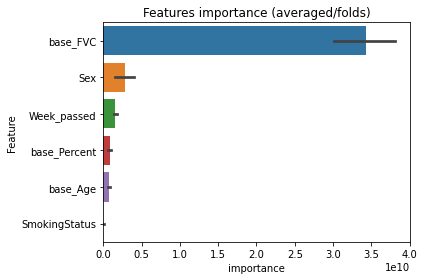

In [ ]:

TARGET = 'FVC'
target = train[TARGET]
test[TARGET] = np.nan

# features
cat_features = ['Sex', 'SmokingStatus']
num_features = [c for c in test.columns 
                if (test.dtypes[c] != 'object') & (c not in cat_features)]
features = num_features + cat_features
drop_features = [ID, TARGET, 'predict_Week', 'base_Week']
features = [c for c in features if c not in drop_features]

if cat_features:
    ce_oe = ce.OrdinalEncoder(cols=cat_features, handle_unknown='impute')
    ce_oe.fit(train)
    train = ce_oe.transform(train)
    test = ce_oe.transform(test)
        
lgb_param = {'objective': 'regression',
             'metric': 'rmse',
             'boosting_type': 'gbdt',
             'learning_rate': 0.01,
             'seed': SEED,
             'max_depth': -1,
             'verbosity': -1,
            }
feature_importance_df, predictions, oof = run_kfold_lightgbm(
                lgb_param, train, test, folds, features, target, 
                n_fold=N_FOLD, categorical=cat_features)
show_feature_importance(feature_importance_df, TARGET)

In [ ]:
train['FVC_pred'] = oof
test['FVC_pred'] = predictions

### Confidence Level

In [ ]:
import math
# baseline score
train['Confidence'] = 100
train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
train['diff'] = abs(train['FVC'] - train['FVC_pred'])
train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - \
                                    np.log(math.sqrt(2)*train['sigma_clipped'])
score = train['score'].mean()
print(score)

-17.516871884983697


In [ ]:
test.head(3)

,Patient_Week,Patient,predict_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,FVC,FVC_pred
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,3020,70.186855,73,1,1,-18,NaN,3271.434609
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,3020,70.186855,73,1,1,-17,NaN,3263.178858
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,3020,70.186855,73,1,1,-16,NaN,3260.911502


In [ ]:
train.head(10)

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,FVC_pred,Confidence,sigma_clipped,diff,delta,score
0,ID00007637202177411956430,5,2214,ID00007637202177411956430_5,-4,2315,58.253649,79,1,1,9,2206.835781,100,100,7.164219,7.164219,-5.053061
1,ID00007637202177411956430,7,2061,ID00007637202177411956430_7,-4,2315,58.253649,79,1,1,11,2182.661662,100,100,121.661662,121.661662,-6.672300
2,ID00007637202177411956430,9,2144,ID00007637202177411956430_9,-4,2315,58.253649,79,1,1,13,2124.350372,100,100,19.649628,19.649628,-5.229631
3,ID00007637202177411956430,11,2069,ID00007637202177411956430_11,-4,2315,58.253649,79,1,1,15,2122.178614,100,100,53.178614,53.178614,-5.703803
4,ID00007637202177411956430,17,2101,ID00007637202177411956430_17,-4,2315,58.253649,79,1,1,21,2106.997809,100,100,5.997809,5.997809,-5.036566
5,ID00007637202177411956430,29,2000,ID00007637202177411956430_29,-4,2315,58.253649,79,1,1,33,2103.404607,100,100,103.404607,103.404607,-6.414106
6,ID00007637202177411956430,41,2064,ID00007637202177411956430_41,-4,2315,58.253649,79,1,1,45,2091.140385,100,100,27.140385,27.140385,-5.335567
7,ID00007637202177411956430,57,2057,ID00007637202177411956430_57,-4,2315,58.253649,79,1,1,61,2091.140385,100,100,34.140385,34.140385,-5.434562
8,ID00007637202177411956430,-4,2315,ID00007637202177411956430_-4,5,2214,55.712129,79,1,1,-9,2190.371176,100,100,124.628824,124.628824,-6.714262
9,ID00007637202177411956430,7,2061,ID00007637202177411956430_7,5,2214,55.712129,79,1,1,2,2160.598889,100,100,99.598889,99.598889,-6.360285


### FVC Distribution

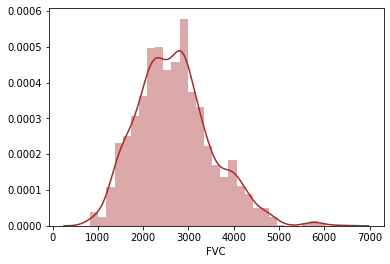

In [ ]:
# seaborn API - https://seaborn.pydata.org/tutorial/function_overview.html
sns.distplot(df_train.FVC, color = "brown");


FVC ranges from 827 to 6399 and seems to have a (visually) normal distribution 
with mean 2690 and standard deviation 833.

Evaluation Metric
 Predict the FVC and confidence value of the prediction. The term confidence (as lower value means more confident) and it might be better to just consider it as the standard deviation (or the uncertainty).

Define a function to understand the metric.



In [ ]:
## evaluation metric function
def laplace_log_likelihood(
    actual_fvc, predicted_fvc, confidence, return_values = False):
    """
    Calculates the modified Laplace Log Likelihood score for this competition.
    """
    standard_deviation_sharp = np.maximum(confidence, 70)
    #print("standard deviation", standard_deviation_sharp)
    delta = np.minimum(np.abs(actual_fvc - predicted_fvc), 1000)
    #print("delta", delta)
    metric = - np.sqrt(2) * delta / standard_deviation_sharp - \
                                  np.log(np.sqrt(2) * standard_deviation_sharp)
    #print("metric", metric)

    if return_values:
        return metric
    else:
        return np.mean(metric)


## default benchmark
#print ('FVC', df_train.FVC)
print ('FVC_mean:', np.mean(df_train.FVC))
print ('FVC_std:', np.std(df_train.FVC))
print ('Confidence:', np.std(df_train.FVC))
laplace_log_likelihood(df_train.FVC, np.mean(df_train.FVC), np.std(df_train.FVC))

FVC_mean: 2690.479018721756
FVC_std: 832.5021066817243
Confidence: 832.5021066817243


-8.023182671302157

**FVC_mean:** 2690.479018721756
**FVC_std:** 832.5021066817243
**FVC Metric:** -8.023182671302157

Constant Prediction
A few combinations of predicting a constant value for FVC and confidence to compare how the errors vary with the actual FVC values




In [ ]:
def plot_metric_constants(actual_fvc, constant_fvc, constant_confidence):
    """
    Generatings a bokeh plot for a constant value of predicted FVC and confidence.
    """
    lll = laplace_log_likelihood(actual_fvc, constant_fvc, constant_confidence)

    df = pd.DataFrame({"actual_FVC": actual_fvc, "predicted_FVC": constant_fvc, "confidence": constant_confidence, 
                       "metric": laplace_log_likelihood(actual_fvc, constant_fvc, constant_confidence, return_values = True)
    }).sort_values("actual_FVC")
    
    #print(df) #df 
    #actual_FVC  predicted_FVC  confidence     metric
    #864          827           2690         100 -19.093879
    #865          828           2690         100 -19.093879
    #1334         837           2690         100 -19.093879

    source = ColumnDataSource(df)
    tooltips = [ ("Actual FVC", "@actual_FVC{0}"), ("Predicted FVC", "@predicted_FVC{0}"), 
                 ("Confidence", "@confidence{0}"),("Metric", "@metric{0.000}")]   
    v = figure( plot_width = 345, plot_height = 345, y_range = Range1d(-4, -25),
        tooltips = tooltips,
        title = f"Metric values for FVC = {constant_fvc}, Confidence = {constant_confidence}"
    )
    v.circle("actual_FVC", "metric", source = source, size = 3, color = "deepskyblue", alpha = 0.8)
    
    mean = Span(location = lll, dimension = "width", line_color = "red", line_dash = "dashed", line_width = 1.5)
    v.add_layout(mean)
    
    score = Label(x = 3500, y = lll + 1.25, text = f"Laplace Log Likelihood = {round(lll, 3)}", text_font_size = "7pt")
    v.add_layout(score)
    
    v.xaxis.axis_label = "Actual FVC"; v.yaxis.axis_label = "Metric Value"

    return v

v1 = plot_metric_constants(df_train.FVC, 2690, 100); v2 = plot_metric_constants(df_train.FVC, 2000, 100)
v3 = plot_metric_constants(df_train.FVC, 3000, 100); v4 = plot_metric_constants(df_train.FVC, 4000, 100)
v5 = plot_metric_constants(df_train.FVC, 2000, 833); v6 = plot_metric_constants(df_train.FVC, 2690, 833)
v7 = plot_metric_constants(df_train.FVC, 3000, 833); v8 = plot_metric_constants(df_train.FVC, 4000, 833)
v9 = plot_metric_constants(df_train.FVC, 2690, 70); v10 = plot_metric_constants(df_train.FVC, 2690, 100)
v11 = plot_metric_constants(df_train.FVC, 2690, 833); v12 = plot_metric_constants(df_train.FVC, 2690, 1000)

show(column(row(v1, v2), row(v3, v4), row(v5, v6), row(v7, v8), row(v9, v10), row(v11, v12)))

**Interactive Simulation**
Try combinations of FVC values to see how the metric value varies over confidence.

Any difference between the FVC values greater than 1000 will yield the same metric values since the delta is capped at 1000.
The metric value is only dependent on the difference of FVC values and not on the absolute values.

In [ ]:
source = ColumnDataSource(data = dict(
    x = range(70, 2001),
    y = [- np.sqrt(2) * 500 / x - np.log(np.sqrt(2) * x) for x in range(70, 2001)]
))

tooltips = [("Confidence", "@x"), ("Metric", "@y")]

v1 = figure( plot_width = 300, plot_height = 300, tooltips = tooltips, title = "Metric values across confidence")
v1.line("x", "y", source = source, width = 4, color = "coral", alpha = 0.8)
v1.y_range.flipped = True
v1.xaxis.axis_label = "Confidence (Uncertainty)"
v1.yaxis.axis_label = "Metric Value"

v2 = figure( plot_width = 300, plot_height = 300, tooltips = tooltips, y_range = Range1d(-4, -25), title = "Metric values across confidence")
v2.line("x", "y", source = source, width = 4, color = "coral", alpha = 0.8)
v2.xaxis.axis_label = "Confidence (Uncertainty)"
v2.yaxis.axis_label = "Metric Value"

slider_actual_FVC = Slider(start = 827, end = 6399, value = 2500, step = 1, title = "Actual FVC")
slider_predicted_FVC = Slider(start = 827, end = 6399, value = 3000, step = 1, title = "Predicted FVC")

callback = CustomJS(args = dict(
    source = source,
    actual_FVC = slider_actual_FVC,
    predicted_FVC = slider_predicted_FVC
), code = """
    var data = source.data
    var actual_FVC = actual_FVC.value
    var predicted_FVC = predicted_FVC.value

    var x = data['x']
    var y = data['y']
    var delta = Math.min(Math.abs(actual_FVC - predicted_FVC), 1000)

    for (var i = 0; i < x.length; i++) {
        y[i] = - Math.sqrt(2) * delta / x[i] - Math.log(Math.sqrt(2) * x[i])
    }

    source.change.emit();
""")

slider_actual_FVC.js_on_change("value", callback)
slider_predicted_FVC.js_on_change("value", callback)

show(column(slider_actual_FVC, slider_predicted_FVC, row(v1, v2)))

While ML models optimize on the point predictions of a target variable (like FVC), it will be interesting to see how the confidence predictions can be optimized. 

In [ ]:
import scipy as sp

def loss_func(weight, row):
    confidence = weight
    sigma_clipped = max(confidence, 70)
    diff = abs(row['FVC'] - row['FVC_pred'])
    delta = min(diff, 1000)
    score = -math.sqrt(2)*delta/sigma_clipped - np.log(math.sqrt(2)*sigma_clipped)
    return -score

results = []
tk0 = tqdm(train.iterrows(), total=len(train))
for _, row in tk0:
    loss_partial = partial(loss_func, row=row)
    weight = [100]
    #bounds = [(70, 100)]
    #result = sp.optimize.minimize(loss_partial, weight, method='SLSQP', bounds=bounds)
    result = sp.optimize.minimize(loss_partial, weight, method='SLSQP')
    x = result['x']
    results.append(x[0])

In [ ]:
# optimized score
train['Confidence'] = results
train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
train['diff'] = abs(train['FVC'] - train['FVC_pred'])
train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
score = train['score'].mean()
print(score)

-8.290356919186934


In [ ]:
train.head(10)

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,FVC_pred,Confidence,sigma_clipped,diff,delta,score
0,ID00007637202177411956430,5,2214,ID00007637202177411956430_5,-4,2315,58.253649,79,1,1,9,2206.835781,62.939957,70.000000,7.164219,7.164219,-4.739808
1,ID00007637202177411956430,7,2061,ID00007637202177411956430_7,-4,2315,58.253649,79,1,1,11,2182.661662,172.032117,172.032117,121.661662,121.661662,-6.494391
2,ID00007637202177411956430,9,2144,ID00007637202177411956430_9,-4,2315,58.253649,79,1,1,13,2124.350372,61.648056,70.000000,19.649628,19.649628,-4.992051
3,ID00007637202177411956430,11,2069,ID00007637202177411956430_11,-4,2315,58.253649,79,1,1,15,2122.178614,62.633704,70.000000,53.178614,53.178614,-5.669439
4,ID00007637202177411956430,17,2101,ID00007637202177411956430_17,-4,2315,58.253649,79,1,1,21,2106.997809,62.169967,70.000000,5.997809,5.997809,-4.716243
5,ID00007637202177411956430,29,2000,ID00007637202177411956430_29,-4,2315,58.253649,79,1,1,33,2103.404607,146.175110,146.175110,103.404607,103.404607,-6.331797
6,ID00007637202177411956430,41,2064,ID00007637202177411956430_41,-4,2315,58.253649,79,1,1,45,2091.140385,21.765136,70.000000,27.140385,27.140385,-5.143387
7,ID00007637202177411956430,57,2057,ID00007637202177411956430_57,-4,2315,58.253649,79,1,1,61,2091.140385,2.454786,70.000000,34.140385,34.140385,-5.284809
8,ID00007637202177411956430,-4,2315,ID00007637202177411956430_-4,5,2214,55.712129,79,1,1,-9,2190.371176,176.222191,176.222191,124.628824,124.628824,-6.518487
9,ID00007637202177411956430,7,2061,ID00007637202177411956430_7,5,2214,55.712129,79,1,1,2,2160.598889,140.821088,140.821088,99.598889,99.598889,-6.294298


Predict Confidence

================================= 4fold lightgbm =================================
================================= 4fold lightgbm =================================
================================= 4fold lightgbm =================================
================================= 4fold lightgbm =================================
len(trn_idx) : 1161
len(trn_idx) : 1161
len(trn_idx) : 1161
len(trn_idx) : 1161
len(val_idx) : 388
len(val_idx) : 388
len(val_idx) : 388
len(val_idx) : 388
fold0 RMSE score: 207.15861
fold0 RMSE score: 207.15861
fold0 RMSE score: 207.15861
fold0 RMSE score: 207.15861
len(trn_idx) : 1162
len(trn_idx) : 1162
len(trn_idx) : 1162
len(trn_idx) : 1162
len(val_idx) : 387
len(val_idx) : 387
len(val_idx) : 387
len(val_idx) : 387


Fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 139.231	valid_1's rmse: 207.477
Early stopping, best iteration is:
[92]	training's rmse: 140.731	valid_1's rmse: 207.159
Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 147.001	valid_1's rmse: 147.659
[200]	training's rmse: 131.507	valid_1's rmse: 143.982
[300]	training's rmse: 121.782	valid_1's rmse: 144.057
Early stopping, best iteration is:
[237]	training's rmse: 127.5	valid_1's rmse: 143.501


fold1 RMSE score: 143.50064
fold1 RMSE score: 143.50064
fold1 RMSE score: 143.50064
fold1 RMSE score: 143.50064
len(trn_idx) : 1162
len(trn_idx) : 1162
len(trn_idx) : 1162
len(trn_idx) : 1162
len(val_idx) : 387
len(val_idx) : 387
len(val_idx) : 387
len(val_idx) : 387


Fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 143.607	valid_1's rmse: 156.065
[200]	training's rmse: 129.069	valid_1's rmse: 154.351
Early stopping, best iteration is:
[170]	training's rmse: 132.816	valid_1's rmse: 154.031


fold2 RMSE score: 154.03078
fold2 RMSE score: 154.03078
fold2 RMSE score: 154.03078
fold2 RMSE score: 154.03078
len(trn_idx) : 1162
len(trn_idx) : 1162
len(trn_idx) : 1162
len(trn_idx) : 1162
len(val_idx) : 387
len(val_idx) : 387
len(val_idx) : 387
len(val_idx) : 387


Fold 3
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 140.953	valid_1's rmse: 147.886
[200]	training's rmse: 124.485	valid_1's rmse: 144.267
[300]	training's rmse: 115.263	valid_1's rmse: 144.595


fold3 RMSE score: 144.02885
fold3 RMSE score: 144.02885
fold3 RMSE score: 144.02885
fold3 RMSE score: 144.02885
CV RMSE score: 1321.41973
CV RMSE score: 1321.41973
CV RMSE score: 1321.41973
CV RMSE score: 1321.41973


Early stopping, best iteration is:
[218]	training's rmse: 122.22	valid_1's rmse: 144.029


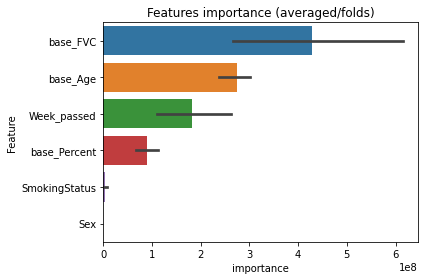

In [ ]:
TARGET = 'Confidence'

target = train[TARGET]
test[TARGET] = np.nan

# features
cat_features = ['Sex', 'SmokingStatus']
num_features = [c for c in test.columns if (test.dtypes[c] != 'object') & (c not in cat_features)]
features = num_features + cat_features
drop_features = [ID, TARGET, 'predict_Week', 'base_Week', 'FVC', 'FVC_pred']
features = [c for c in features if c not in drop_features]

lgb_param = {'objective': 'regression',
             'metric': 'rmse',
             'boosting_type': 'gbdt',
             'learning_rate': 0.01,
             'seed': SEED,
             'max_depth': -1,
             'verbosity': -1,
            }

feature_importance_df, predictions, oof = run_kfold_lightgbm(lgb_param, train, test, folds, features, target, 
                                                             n_fold=N_FOLD, categorical=cat_features)
    
show_feature_importance(feature_importance_df, TARGET)

In [ ]:
train['Confidence'] = oof
train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
train['diff'] = abs(train['FVC'] - train['FVC_pred'])
train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
score = train['score'].mean()
print(score)

-22.449700799863674


In [ ]:
def lb_metric(train):
    train['Confidence'] = oof
    train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
    train['diff'] = abs(train['FVC'] - train['FVC_pred'])
    train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
    train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
    score = train['score'].mean()
    return score

In [ ]:
test['Confidence'] = predictions

Locl score

In [ ]:
score = lb_metric(train)
logger.info(f'Local Score: {score}')

Local Score: -22.449700799863674
Local Score: -22.449700799863674
Local Score: -22.449700799863674
Local Score: -22.449700799863674


In [ ]:
test['Confidence'] = predictions

Submissions


In [ ]:
submission.head()

,Patient_Week,FVC,Confidence,Patient,predict_Week
0,ID00419637202311204720264_-12,2000,100,ID00419637202311204720264,-12
1,ID00421637202311550012437_-12,2000,100,ID00421637202311550012437,-12
2,ID00422637202311677017371_-12,2000,100,ID00422637202311677017371,-12
3,ID00423637202312137826377_-12,2000,100,ID00423637202312137826377,-12
4,ID00426637202313170790466_-12,2000,100,ID00426637202313170790466,-12


In [ ]:
sub = submission.drop(columns=['FVC', 'Confidence']).merge(test[['Patient_Week', 'FVC_pred', 'Confidence']], 
                                                           on='Patient_Week')
sub.columns = submission.columns
sub.to_csv('submission.csv', index=False)
sub.head()

,Patient_Week,FVC,Confidence,Patient,predict_Week
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,3271.434609,199.396833
1,ID00421637202311550012437_-12,ID00421637202311550012437,-12,2952.661183,154.916023
2,ID00422637202311677017371_-12,ID00422637202311677017371,-12,2457.731782,161.206649
3,ID00423637202312137826377_-12,ID00423637202312137826377,-12,3457.315164,199.647896
4,ID00426637202313170790466_-12,ID00426637202313170790466,-12,3012.532384,243.651832


### Model

ML Prediction
Let's look at the out-of-fold predictions of some of the ML models. 

In [ ]:
df_preds = pd.read_csv(
    "/data/My Drive/data/osic-pulmonary-fibrosis-progression/train.csv")

def plot_fvc_metric_model(actual_fvc, predicted_fvc, 
                          predicted_confidence, constant = False):
    """Generatings a bokeh plot for the metric values across actual values of FVC. """
    lll = laplace_log_likelihood(actual_fvc, predicted_fvc, predicted_confidence)
    """
    df = pd.DataFrame({"actual_FVC": actual_fvc, "predicted_FVC": constant_fvc, 
                       "confidence": constant_confidence, 
                       "metric": laplace_log_likelihood(actual_fvc, constant_fvc, 
                        constant_confidence, return_values = True)
    }).sort_values("actual_FVC")  """
    
    metric_values = laplace_log_likelihood(actual_fvc, predicted_fvc, 
                                  predicted_confidence, return_values = True)

    df = pd.DataFrame({"actual_FVC": actual_fvc,
                       "predicted_FVC": predicted_fvc,
                       "confidence": predicted_confidence,
                       "metric": metric_values
    }).sort_values("actual_FVC")
    source = ColumnDataSource(df)
    tooltips = [("Actual FVC", "@actual_FVC{0}"),
                ("Predicted FVC", "@predicted_FVC{0}"),
                ("Confidence", "@confidence{0}"),
                ("Metric", "@metric{0.000}")]
    if type(predicted_confidence) != int:
        title = f"Metric values over FVC"
        offset = 0.35
    else:
        title = f"Metric values over FVC (Confidence = {predicted_confidence})"
        offset = 0.11

    v = figure(
        plot_width = 600, plot_height = 600, 
        y_range = Range1d(max(metric_values) + 0.5, min(metric_values) - 0.5),
        tooltips = tooltips, title = title
    )
    v.circle("actual_FVC", "metric", source = source, size = 3, 
             color = "mediumseagreen", alpha = 0.8)
    mean = Span(location = lll, dimension = "width", line_color = "red", 
                line_dash = "dashed", line_width = 1.5)
    v.add_layout(mean)
    score = Label(x = 3750, y = lll + offset, 
                  text = f"Laplace Log Likelihood = {round(lll, 3)}", 
                  text_font_size = "12pt")
    v.add_layout(score)
    v.xaxis.axis_label = "Actual FVC"
    v.yaxis.axis_label = "Metric Value"
    print(v)
    return v


def plot_confidence_metric_model(actual_fvc, predicted_fvc, predicted_confidence):
    """ Generatings a bokeh plot for the metric values 
    across predicted values of confidence. """
    lll = laplace_log_likelihood(actual_fvc, predicted_fvc, predicted_confidence)
    """
    df = pd.DataFrame({"actual_FVC": actual_fvc, 
                       "predicted_FVC": constant_fvc, 
                       "confidence": constant_confidence, 
                       "metric": laplace_log_likelihood(actual_fvc, 
                       constant_fvc, constant_confidence, 
                       return_values = True)
    }).sort_values("confidence") """

    metric_values = laplace_log_likelihood(actual_fvc, predicted_fvc, 
                                           predicted_confidence, 
                                           return_values = True)
    df = pd.DataFrame({"actual_FVC": actual_fvc, 
                       "predicted_FVC": predicted_fvc, 
                       "confidence": predicted_confidence, 
                       #"metric": metric_values
                       "metric": laplace_log_likelihood(actual_fvc, 
                                            constant_fvc, constant_confidence, 
                                            return_values = True)
    }).sort_values("confidence")
    source = ColumnDataSource(df)
    tooltips = [("Actual FVC", "@actual_FVC{0}"), 
                ("Predicted FVC", "@predicted_FVC{0}"), 
                ("Confidence", "@confidence{0}"),
                ("Metric", "@metric{0.000}")]
    v = figure( 
        plot_width = 600, plot_height = 600, 
        y_range = Range1d(max(metric_values) + 0.5, min(metric_values) - 0.5),
        tooltips = tooltips, title = "Metric values over Confidence"
    )
    v.circle("confidence", "metric", source = source, size = 3, 
             color = "gold", alpha = 0.8)
    mean = Span(location = lll, dimension = "width", line_color = "red", 
                line_dash = "dashed", line_width = 1.5)
    v.add_layout(mean)
    score = Label(x = 600, y = lll + 0.35, 
                  text = f"Laplace Log Likelihood = {round(lll, 3)}", 
                  text_font_size = "12pt")
    v.add_layout(score)
    v.xaxis.axis_label = "Predicted Confidence"
    v.yaxis.axis_label = "Metric Value"
    return v

def plot_pred_metric_model(actual_fvc, predicted_fvc, predicted_confidence):
    """ Generatings a bokeh plot for the metric values across predicted values of FVC. """
    lll = laplace_log_likelihood(actual_fvc, predicted_fvc, predicted_confidence)
    """
    df = pd.DataFrame({"actual_FVC": actual_fvc, 
                       "predicted_FVC": constant_fvc, 
                       "confidence": constant_confidence, 
                       "metric": laplace_log_likelihood(actual_fvc, constant_fvc, 
                                    constant_confidence, return_values = True)
    }).sort_values("predicted_FVC") """

    metric_values = laplace_log_likelihood(actual_fvc, 
                                           predicted_fvc, 
                                           predicted_confidence, 
                                           return_values = True)
    df = pd.DataFrame({"actual_FVC": actual_fvc,
                       "predicted_FVC": predicted_fvc,
                       "confidence": predicted_confidence,
                       "metric": metric_values
    }).sort_values("predicted_FVC")

    source = ColumnDataSource(df)
    tooltips = [("Actual FVC", "@actual_FVC{0}"),
                ("Predicted FVC", "@predicted_FVC{0}"),
                ("Confidence", "@confidence{0}"),
                ("Metric", "@metric{0.000}")]
    v = figure(plot_width = 600, plot_height = 600, 
               y_range = Range1d(max(metric_values) + 0.5, 
               min(metric_values) - 0.5),
        tooltips = tooltips,title = "Metric values over predicted FVC"
    )
    v.circle("predicted_FVC", "metric", source = source, 
             size = 3, color = "turquoise", alpha = 0.8)
    mean = Span(location = lll, dimension = "width", 
                line_color = "red", line_dash = "dashed", line_width = 1.5)
    v.add_layout(mean)
    score = Label(x = 3500, y = lll + 0.35,
        text = f"Laplace Log Likelihood = {round(lll, 3)}", 
        text_font_size = "12pt"
    )
    v.add_layout(score)

    v.xaxis.axis_label = "Predicted FVC"
    v.yaxis.axis_label = "Metric Value"
    return v

#sns.pairplot(df_preds[["FVC", "predicted_FVC", "confidence"]])
#sns.pairplot(df_preds[["FVC", "FVC_pred", "Confidence"]])


Visualization- CT scans

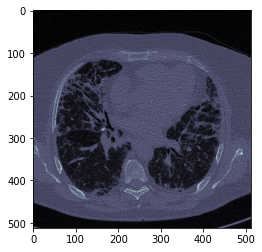

In [ ]:
#View Single Image
filename = "/data/My Drive/data/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140/137.dcm"
ds = pydicom.dcmread(filename)
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)

In [ ]:
#image sizes 
pydicom.dcmread(filename).pixel_array.shape
#image meta-data 
pydicom.dcmread(filename)

In [ ]:
#Extracting meta-data
dir(pydicom.dcmread(filename))


In [ ]:
#Image orientation
dir(pydicom.dcmread(filename)['ImageOrientationPatient'])

In [ ]:
import json
pydicom.dcmread(filename)['ImageOrientationPatient'].to_json()

'{"Value": [1.0, 0.0, 0.0, 0.0, 1.0, 0.0], "vr": "DS"}'

In [ ]:
json.loads(pydicom.dcmread(filename)['ImageOrientationPatient'].to_json())['Value']

[1.0, 0.0, 0.0, 0.0, 1.0, 0.0]

In [ ]:
# Images directory for a patient
imdir = "/data/My Drive/data/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140/"
print("total images for patient ID00123637202217151272140: ", len(os.listdir(imdir)))

total images for patient ID00123637202217151272140:  258


In [ ]:
#Images in training set
img_path = "/data/My Drive/data/osic-pulmonary-fibrosis-progression/train/"
files = folders = 0
for _, dirnames, filenames in os.walk(img_path):
     files += len(filenames)
     folders += len(dirnames)
print("{:,} files/images, {:,} folders/patients".format(files, folders))
print("{:,} average files/images per patient".format(round(np.mean(files))))
print("{:,} max files/images per patient".format(round(np.max(files))))
print("{:,} min files/images per patient".format(round(np.min(files))))

33,088 files/images, 176 folders/patients
33,088.0 average files/images per patient
33,088 max files/images per patient
33,088 min files/images per patient


Filename.........:  /data/My Drive/data/osic-pulmonary-fibrosis-progression/train/ID00067637202189903532242/100.dcm

Patient's name......:  ID00067637202189903532242, 
Patient id..........:  ID00067637202189903532242
Patient's Sex.......:  
Modality............:  CT
Body Part Examined..:  Chest
Image size.......:   733 x 888, 1301808 bytes
Pixel spacing....:  [0.871094, 0.871094]


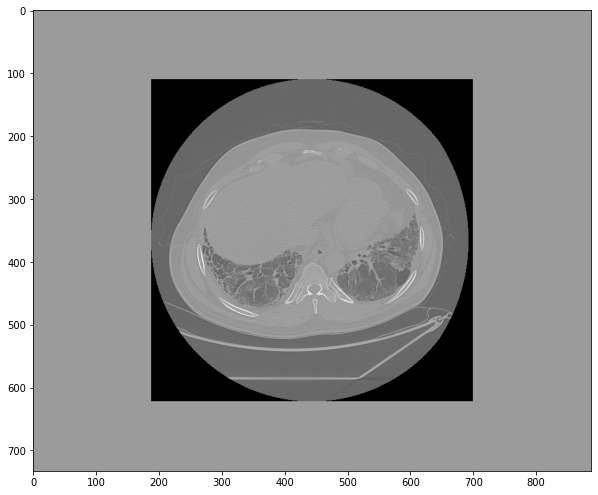

In [ ]:
import glob
!pip install colorama
from colorama import init, Fore, Back, Style

def show_dcm_info(dataset):
    print(Fore.YELLOW + "Filename.........:",Style.RESET_ALL,file_path)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print(Fore.BLUE + "Patient's name......:",Style.RESET_ALL, display_name)
    print(Fore.BLUE + "Patient id..........:",Style.RESET_ALL, dataset.PatientID)
    print(Fore.BLUE + "Patient's Sex.......:",Style.RESET_ALL, dataset.PatientSex)
    print(Fore.YELLOW + "Modality............:",Style.RESET_ALL, dataset.Modality)
    print(Fore.GREEN + "Body Part Examined..:",Style.RESET_ALL, dataset.BodyPartExamined)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print(Fore.BLUE + "Image size.......:",Style.RESET_ALL," {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print(Fore.YELLOW + "Pixel spacing....:",Style.RESET_ALL,dataset.PixelSpacing)
            dataset.PixelSpacing = [1, 1]
        plt.figure(figsize=(10, 10))
        plt.imshow(dataset.pixel_array, cmap='gray')
        plt.show()
for file_path in glob.glob('/data/My Drive/data/osic-pulmonary-fibrosis-progression/train/*/*.dcm'):
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    break # Comment this out to see all

total images for patient ID00123637202217151272140:  258


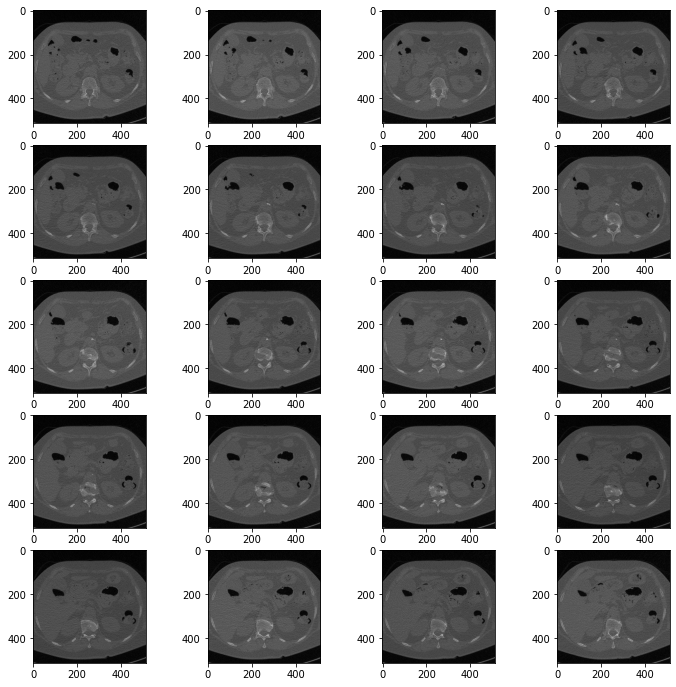

In [ ]:
imdir = "/data/My Drive/data/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140"
print("total images for patient ID00123637202217151272140: ", len(os.listdir(imdir)))

# view first (columns*rows) images in order
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 5
imglist = os.listdir(imdir)
for i in range(1, columns*rows +1):
    filename = imdir + "/" + str(i) + ".dcm"
    ds = pydicom.dcmread(filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap='gray')
plt.show()